In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import missingno as msno

import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
seed_value = 99
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

sns.set_theme(style="darkgrid", context= "paper")

In [2]:
HMDA_clean_final = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/HMDA_clean_final.pkl")

In [3]:
HMDA_clean_final['loan_granted'] = (HMDA_clean_final['loan_granted'] == 'Granted').astype(int)

HMDA_encoded = pd.get_dummies(HMDA_clean_final, columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=True)

X = HMDA_encoded.drop(columns=['loan_granted'])
y = HMDA_encoded['loan_granted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [4]:
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(545238, 18) (136310, 18) (170388, 18)
(545238,) (136310,) (170388,)


In [5]:
BLD_train_df = pd.get_dummies(HMDA_clean_final.loc[X_train.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)

In [6]:
for col in BLD_train_df.columns:
    if BLD_train_df[col].dtype == 'bool':
        BLD_train_df[col] = BLD_train_df[col].astype(int)

In [7]:
BLD_train_df.head()

county_code  interest_rate  loan_to_value_ratio  loan_granted  \
115410       30013       4.990000           100.000000             1   
630420       48119       4.560661            71.241202             0   
612581       48085       4.560661            71.241202             0   
670964       48085       4.560661            71.241202             1   
179727       30111       7.000000            52.055000             1   

        applicant_sex_Male  applicant_sex_Female  \
115410                   1                     0   
630420                   1                     0   
612581                   1                     0   
670964                   1                     0   
179727                   1                     0   

        applicant_race-1_Black or African American  applicant_race-1_White  \
115410                                           0                       1   
630420                                           1                       0   
612581                                           0                       1   
670964                                           0                       1   
179727                                           0                       1   

        loan_type_Conventional  loan_type_FHA  ...  \
115410                       0              0  ...   
630420                       1              0  ...   
612581                       1              0  ...   
670964                       1              0  ...   
179727                       1              0  ...   

        debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
115410                                   0                             0   
630420                                   0                             0   
612581                                   0                             0   
670964                                   0                             0   
179727                                   1                             0   

        debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
115410                             0                             0   
630420                             0                             1   
612581                             0                             0   
670964                             0                             0   
179727                             0                             0   

        debt_to_income_ratio_50%-60%  debt_to_income_ratio_<20%  \
115410                             1                          0   
630420                             0                          0   
612581                             0                          0   
670964                             0                          1   
179727                             0                          0   

        debt_to_income_ratio_>60%  debt_to_income_ratio_missing  \
115410                          0                             0   
630420                          0                             0   
612581                          0                             1   
670964                          0                             0   
179727                          0                             0   

        lien_status_First lien  lien_status_Subordinate lien  
115410                       1                             0  
630420                       1                             0  
612581                       0                             1  
670964                       1                             0  
179727                       0                             1  

[5 rows x 24 columns]

In [8]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

pip install 'aif360[inFairness]'


In [9]:
privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

privileged_groups_2 = [{'applicant_sex_Male': 1}]
unprivileged_groups_2 = [{'applicant_sex_Male': 0}]

train_bld = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
train_bld_2 = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_sex_Male', 'applicant_sex_Female'], favorable_label=1.0, unfavorable_label=0.0)


metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_train_2 = BinaryLabelDatasetMetric(train_bld_2, 
                                             unprivileged_groups=unprivileged_groups_2,
                                             privileged_groups=privileged_groups_2)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_train.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups - Sex = %f" % metric_orig_train_2.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.148808
Difference in mean outcomes between unprivileged and privileged groups - Sex = -0.036731


In [10]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(train_bld)

In [11]:
class_weights_array = dataset_transf_train.instance_weights

In [12]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print(metric_orig_train.disparate_impact())
print(metric_transf_train.disparate_impact())

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_transf_train.mean_difference())

0.7528037780827889
0.9999999999999997
Difference in mean outcomes between unprivileged and privileged groups - Race = -0.000000


In [13]:
print(pd.DataFrame(train_bld.convert_to_dataframe()[0][["county_code", "interest_rate", "loan_to_value_ratio"]]).head(), "\n", "\n", X_train[["county_code", "interest_rate", "loan_to_value_ratio"]].head())

        county_code  interest_rate  loan_to_value_ratio
115410      30013.0       4.990000           100.000000
630420      48119.0       4.560661            71.241202
612581      48085.0       4.560661            71.241202
670964      48085.0       4.560661            71.241202
179727      30111.0       7.000000            52.055000 
 
        county_code  interest_rate  loan_to_value_ratio
115410       30013       4.990000           100.000000
630420       48119       4.560661            71.241202
612581       48085       4.560661            71.241202
670964       48085       4.560661            71.241202
179727       30111       7.000000            52.055000


In [14]:
X_train.astype(float).describe()

county_code  interest_rate  loan_to_value_ratio  \
count  545238.000000  545238.000000        545238.000000   
mean    43877.231382       4.560750            71.250975   
std      9573.854372       1.207122            18.529292   
min     22001.000000       0.000000             0.000000   
25%     48029.000000       4.560661            71.241202   
50%     48201.000000       4.560661            71.241202   
75%     48439.000000       4.740000            78.247750   
max     49057.000000      18.990000           250.000000   

       applicant_sex_Female  applicant_race-1_White  loan_type_FHA  \
count         545238.000000           545238.000000  545238.000000   
mean               0.347368                0.845618       0.105189   
std                0.476134                0.361315       0.306797   
min                0.000000                0.000000       0.000000   
25%                0.000000                1.000000       0.000000   
50%                0.000000                1.000000       0.000000   
75%                1.000000                1.000000       0.000000   
max                1.000000                1.000000       1.000000   

        loan_type_VA  loan_type_FSA/RHS  debt_to_income_ratio_20%-<30%  \
count  545238.000000      545238.000000                  545238.000000   
mean        0.070549           0.008565                       0.115318   
std         0.256070           0.092151                       0.319406   
min         0.000000           0.000000                       0.000000   
25%         0.000000           0.000000                       0.000000   
50%         0.000000           0.000000                       0.000000   
75%         0.000000           0.000000                       0.000000   
max         1.000000           1.000000                       1.000000   

       debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
count                       545238.000000                 545238.000000   
mean                             0.111073                      0.144432   
std                              0.314222                      0.351528   
min                              0.000000                      0.000000   
25%                              0.000000                      0.000000   
50%                              0.000000                      0.000000   
75%                              0.000000                      0.000000   
max                              1.000000                      1.000000   

       debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
count                 545238.000000                 545238.000000   
mean                       0.108054                      0.084345   
std                        0.310449                      0.277905   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.000000   
75%                        0.000000                      0.000000   
max                        1.000000                      1.000000   

       debt_to_income_ratio_50%-60%  debt_to_income_ratio_<20%  \
count                 545238.000000              545238.000000   
mean                       0.063625                   0.047093   
std                        0.244085                   0.211838   
min                        0.000000                   0.000000   
25%                        0.000000                   0.000000   
50%                        0.000000                   0.000000   
75%                        0.000000                   0.000000   
max                        1.000000                   1.000000   

       debt_to_income_ratio_>60%  debt_to_income_ratio_missing  \
count              545238.000000                 545238.000000   
mean                    0.040947                      0.261301   
std                     0.198168                      0.439344   
min          

In [15]:
'''
directory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'

os.makedirs(directory, exist_ok=True)

pickle_file = os.path.join(directory, 'subsets_data.pickle')

subsets = {
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'X_val_scaled': X_val_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
}

with open(pickle_file, 'wb') as f:
    pickle.dump(subsets, f)
'''

"\ndirectory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'\n\nos.makedirs(directory, exist_ok=True)\n\npickle_file = os.path.join(directory, 'subsets_data.pickle')\n\nsubsets = {\n    'X_train_scaled': X_train_scaled,\n    'X_test_scaled': X_test_scaled,\n    'X_val_scaled': X_val_scaled,\n    'y_train': y_train,\n    'y_test': y_test,\n    'y_val': y_val\n}\n\nwith open(pickle_file, 'wb') as f:\n    pickle.dump(subsets, f)\n"

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping_rew = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_checkpoint_rew = ModelCheckpoint('best_model_rew.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model_rew = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.3460 - accuracy: 0.8755 - val_loss: 0.3023 - val_accuracy: 0.8940
Epoch 2/30
11360/11360 [==============================] - 22s 2ms/step - loss: 0.3051 - accuracy: 0.8922 - val_loss: 0.2976 - val_accuracy: 0.8934
Epoch 3/30
11360/11360 [==============================] - 22s 2ms/step - loss: 0.2996 - accuracy: 0.8946 - val_loss: 0.2881 - val_accuracy: 0.8986
Epoch 4/30
11360/11360 [==============================] - 42s 4ms/step - loss: 0.2951 - accuracy: 0.8966 - val_loss: 0.2824 - val_accuracy: 0.9027
Epoch 5/30
11360/11360 [==============================] - 53s 5ms/step - loss: 0.2924 - accuracy: 0.8975 - val_loss: 0.2866 - val_accuracy: 0.8997
Epoch 6/30
11360/11360 [==============================] - 28s 2ms/step - loss: 0.2898 - accuracy: 0.8986 - val_loss: 0.2842 - val_accuracy: 0.8993
Epoch 7/30
11360/11360 [==============================] - 27s 2ms/step - loss: 0.2904 - accuracy: 0.8984 - val_loss: 0

In [17]:
# show a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                608       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [18]:
model_rew.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_rew = model_rew.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping_rew, model_checkpoint_rew], sample_weight=class_weights_array)

Epoch 1/30
11360/11360 [==============================] - 29s 2ms/step - loss: 0.3439 - accuracy: 0.8774 - val_loss: 0.3039 - val_accuracy: 0.8927
Epoch 2/30
11360/11360 [==============================] - 26s 2ms/step - loss: 0.3039 - accuracy: 0.8937 - val_loss: 0.2993 - val_accuracy: 0.8937
Epoch 3/30
11360/11360 [==============================] - 26s 2ms/step - loss: 0.2994 - accuracy: 0.8950 - val_loss: 0.2938 - val_accuracy: 0.8971
Epoch 4/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.2966 - accuracy: 0.8965 - val_loss: 0.2837 - val_accuracy: 0.9022
Epoch 5/30
11360/11360 [==============================] - 27s 2ms/step - loss: 0.2953 - accuracy: 0.8971 - val_loss: 0.2902 - val_accuracy: 0.8963
Epoch 6/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.2949 - accuracy: 0.8975 - val_loss: 0.2867 - val_accuracy: 0.9019
Epoch 7/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.2950 - accuracy: 0.8976 - val_loss: 0

5325/5325 - 4s - loss: 0.2787 - accuracy: 0.9049 - 4s/epoch - 784us/step
5325/5325 - 5s - loss: 0.2840 - accuracy: 0.9025 - 5s/epoch - 868us/step

Test accuracy: 0.9048935174942017

Test accuracy reweighted: 0.9024931192398071


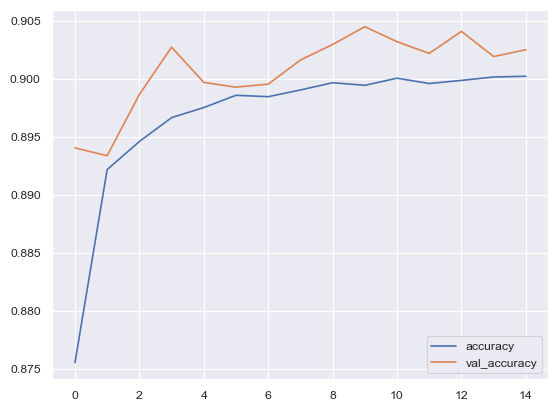

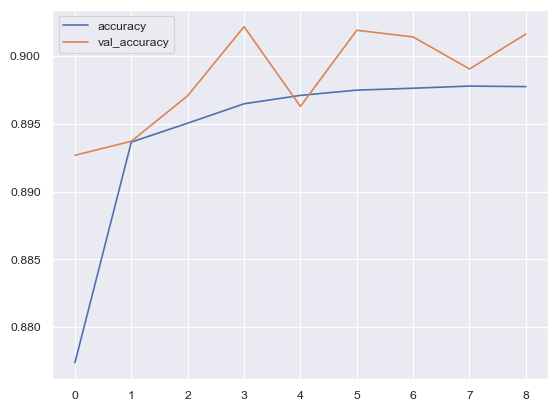

In [19]:
history_df = pd.DataFrame(history.history)
history_df_rew = pd.DataFrame(history_rew.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
history_df_rew.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
test_loss_rew, test_acc_rew = model_rew.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest accuracy reweighted:', test_acc_rew)

5325/5325 [==============================] - 4s 831us/step
[[58374 13274]
 [ 2931 95809]]
[[57967 13681]
 [ 2933 95807]]
Accuracy: 0.9048935371035519
Precision: 0.8783128443478819
Recall: 0.9703159813652016
F1 Score: 0.9220249924214357
Accuracy reweighted: 0.9024931333192479
Precision reweighted: 0.8750456671050709
Recall reweighted: 0.9702957261494835
F1 Score reweighted: 0.9202124594194825
AUC: 0.9439707310493188
AUC reweighted: 0.9419405411065762


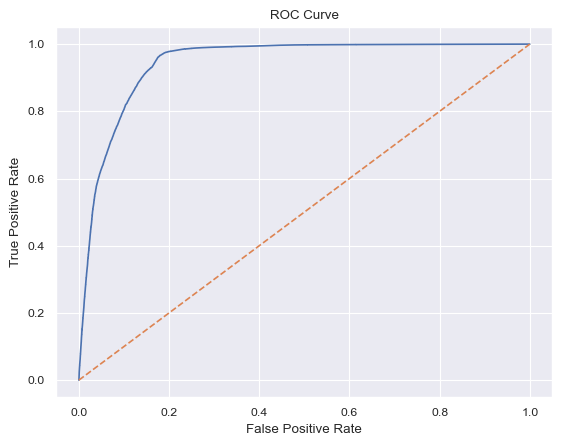

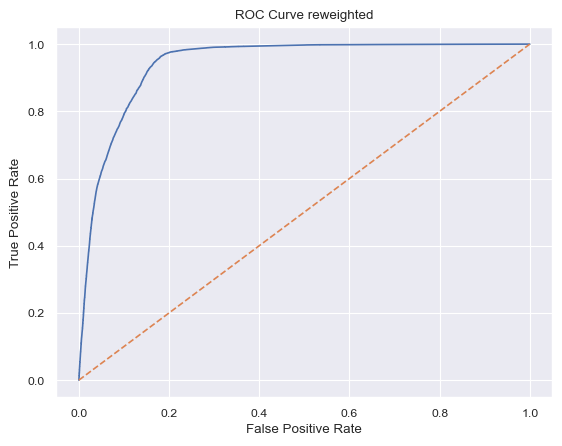

In [20]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5)
y_pred_proba = y_pred_proba.ravel()

y_pred_proba_rew = model_rew.predict(X_test_scaled)
y_pred_rew = (y_pred_proba_rew > 0.5)
y_pred_proba_rew = y_pred_proba_rew.ravel()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

cm_rew = confusion_matrix(y_test, y_pred_rew)
print(cm_rew)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("Accuracy reweighted:", accuracy_score(y_test, y_pred_rew))
print("Precision reweighted:", precision_score(y_test, y_pred_rew))
print("Recall reweighted:", recall_score(y_test, y_pred_rew))
print("F1 Score reweighted:", f1_score(y_test, y_pred_rew))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fprr, tprr, thresholdsr = roc_curve(y_test, y_pred_proba_rew)

from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_proba))

print("AUC reweighted:", roc_auc_score(y_test, y_pred_proba_rew))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

plt.plot(fprr, tprr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve reweighted')
plt.show()

In [21]:
# calculate performance metrics of the original data separately for applicant_race-1_White and applicant_race-1_Black or African American
mask_white = X_test['applicant_race-1_White'] == 1
mask_black = X_test['applicant_race-1_White'] == 0

y_test_white = y_test[mask_white]
y_test_black = y_test[mask_black]

y_pred_white = y_pred[mask_white]
y_pred_black = y_pred[mask_black]

y_pred_proba_white = y_pred_proba[mask_white]
y_pred_proba_black = y_pred_proba[mask_black]
'''
print("Accuracy White:", accuracy_score(y_test_white, y_pred_white))
print("Precision White:", precision_score(y_test_white, y_pred_white))
print("Recall White:", recall_score(y_test_white, y_pred_white))
print("F1 Score White:", f1_score(y_test_white, y_pred_white))

print("Accuracy Black:", accuracy_score(y_test_black, y_pred_black))
print("Precision Black:", precision_score(y_test_black, y_pred_black))
print("Recall Black:", recall_score(y_test_black, y_pred_black))
print("F1 Score Black:", f1_score(y_test_black, y_pred_black))

print("AUC White:", roc_auc_score(y_test_white, y_pred_proba_white))
print("AUC Black:", roc_auc_score(y_test_black, y_pred_proba_black))
'''


y_pred_white_rew = y_pred_rew[mask_white]
y_pred_black_rew = y_pred_rew[mask_black]

y_pred_proba_white_rew = y_pred_proba_rew[mask_white]
y_pred_proba_black_rew = y_pred_proba_rew[mask_black]
'''
print("Accuracy White reweighted:", accuracy_score(y_test_white, y_pred_white_rew))
print("Precision White reweighted:", precision_score(y_test_white, y_pred_white_rew))
print("Recall White reweighted:", recall_score(y_test_white, y_pred_white_rew))
print("F1 Score White reweighted:", f1_score(y_test_white, y_pred_white_rew))

print("Accuracy Black reweighted:", accuracy_score(y_test_black, y_pred_black_rew))
print("Precision Black reweighted:", precision_score(y_test_black, y_pred_black_rew))
print("Recall Black reweighted:", recall_score(y_test_black, y_pred_black_rew))
print("F1 Score Black reweighted:", f1_score(y_test_black, y_pred_black_rew))

print("AUC White reweighted:", roc_auc_score(y_test_white, y_pred_proba_white_rew))
print("AUC Black reweighted:", roc_auc_score(y_test_black, y_pred_proba_black_rew))
'''
# create a dataframe presenting the above results next to each other
comp_df_orig_rew = pd.DataFrame({"Original": [accuracy_score(y_test_white, y_pred_white), precision_score(y_test_white, y_pred_white), recall_score(y_test_white, y_pred_white), f1_score(y_test_white, y_pred_white), roc_auc_score(y_test_white, y_pred_proba_white),
                                     accuracy_score(y_test_black, y_pred_black), precision_score(y_test_black, y_pred_black), recall_score(y_test_black, y_pred_black), f1_score(y_test_black, y_pred_black), roc_auc_score(y_test_black, y_pred_proba_black)],
                                     "Reweighted": [accuracy_score(y_test_white, y_pred_white_rew), precision_score(y_test_white, y_pred_white_rew), recall_score(y_test_white, y_pred_white_rew), f1_score(y_test_white, y_pred_white_rew), roc_auc_score(y_test_white, y_pred_proba_white_rew),
                                                    accuracy_score(y_test_black, y_pred_black_rew), precision_score(y_test_black, y_pred_black_rew), recall_score(y_test_black, y_pred_black_rew), f1_score(y_test_black, y_pred_black_rew), roc_auc_score(y_test_black, y_pred_proba_black_rew)]},)

comp_df_orig_rew.index = ["Accuracy White", "Precision White", "Recall White", "F1 Score White", "AUC White", "Accuracy Black", "Precision Black", "Recall Black", "F1 Score Black", "AUC Black"]

comp_df_orig_rew

Original  Reweighted
Accuracy White   0.908695    0.906631
Precision White  0.887436    0.885204
Recall White     0.971756    0.970995
F1 Score White   0.927684    0.926117
AUC White        0.941588    0.940123
Accuracy Black   0.884210    0.879976
Precision Black  0.816840    0.807631
Recall Black     0.959903    0.965238
F1 Score Black   0.882612    0.879429
AUC Black        0.947980    0.947376

In [22]:
results = pd.DataFrame({'label': y_test})
results["score"] = y_pred.astype(int)
results["applicant_sex"] = HMDA_clean_final.loc[results.index, "applicant_sex"]
results["applicant_race-1"] = HMDA_clean_final.loc[results.index, "applicant_race-1"]

results_rew = pd.DataFrame({'label': y_test})
results_rew["score"] = y_pred_rew.astype(int)
results_rew["applicant_sex"] = HMDA_clean_final.loc[results_rew.index, "applicant_sex"]
results_rew["applicant_race-1"] = HMDA_clean_final.loc[results_rew.index, "applicant_race-1"]

results["label"] = results["label"].astype("int")
results["score"] = results["score"].astype("int")

results_rew["label"] = results_rew["label"].astype("int")
results_rew["score"] = results_rew["score"].astype("int")

results["applicant_sex"] = results["applicant_sex"].astype("object")
results["applicant_race-1"] = results["applicant_race-1"].astype("object")

results_rew["applicant_sex"] = results_rew["applicant_sex"].astype("object")
results_rew["applicant_race-1"] = results_rew["applicant_race-1"].astype("object")

In [23]:
print(results.head(), "\n", results.shape, "\n", results.dtypes, "\n", results_rew.head(), "\n", results_rew.shape, "\n", results_rew.dtypes)

        label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      0        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1    object
dtype: object 
         label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      0        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1   

In [24]:
import aequitas

audit = aequitas.Audit(results)
audit_rew = aequitas.Audit(results_rew)

In [25]:
g = aequitas.group.Group()

results_ren = results.copy()
results_ren["label_value"] = results["label"]
results_ren.drop(columns="label", inplace=True)

results_ren_rew = results_rew.copy()
results_ren_rew["label_value"] = results_rew["label"]
results_ren_rew.drop(columns="label", inplace=True)

xtab, _ = g.get_crosstabs(results_ren)
xtab_rew, _ = g.get_crosstabs(results_ren_rew)

In [26]:
absolute_metrics = g.list_absolute_metrics(xtab)
absolute_metrics_rew = g.list_absolute_metrics(xtab_rew)

In [27]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

attribute_name            attribute_value  accuracy   tpr   tnr   for  \
0     applicant_sex                     Female      0.90  0.97  0.82  0.05   
1     applicant_sex                       Male      0.91  0.97  0.81  0.05   
2  applicant_race-1  Black or African American      0.88  0.96  0.82  0.04   
3  applicant_race-1                      White      0.91  0.97  0.81  0.05   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.13  0.18  0.03  0.95       0.87  0.34   0.62  0.56  
1  0.12  0.19  0.03  0.95       0.88  0.66   0.65  0.59  
2  0.18  0.18  0.04  0.96       0.82  0.13   0.53  0.45  
3  0.11  0.19  0.03  0.95       0.89  0.87   0.66  0.60

In [28]:
xtab_rew[['attribute_name', 'attribute_value'] + absolute_metrics_rew].round(2)

attribute_name            attribute_value  accuracy   tpr   tnr   for  \
0     applicant_sex                     Female      0.90  0.97  0.81  0.05   
1     applicant_sex                       Male      0.90  0.97  0.81  0.05   
2  applicant_race-1  Black or African American      0.88  0.97  0.81  0.03   
3  applicant_race-1                      White      0.91  0.97  0.81  0.05   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.13  0.19  0.03  0.95       0.87  0.34   0.62  0.56  
1  0.12  0.19  0.03  0.95       0.88  0.66   0.65  0.59  
2  0.19  0.19  0.03  0.97       0.81  0.13   0.54  0.45  
3  0.11  0.19  0.03  0.95       0.89  0.87   0.66  0.60

In [29]:
aqp = aequitas.plotting.Plot()

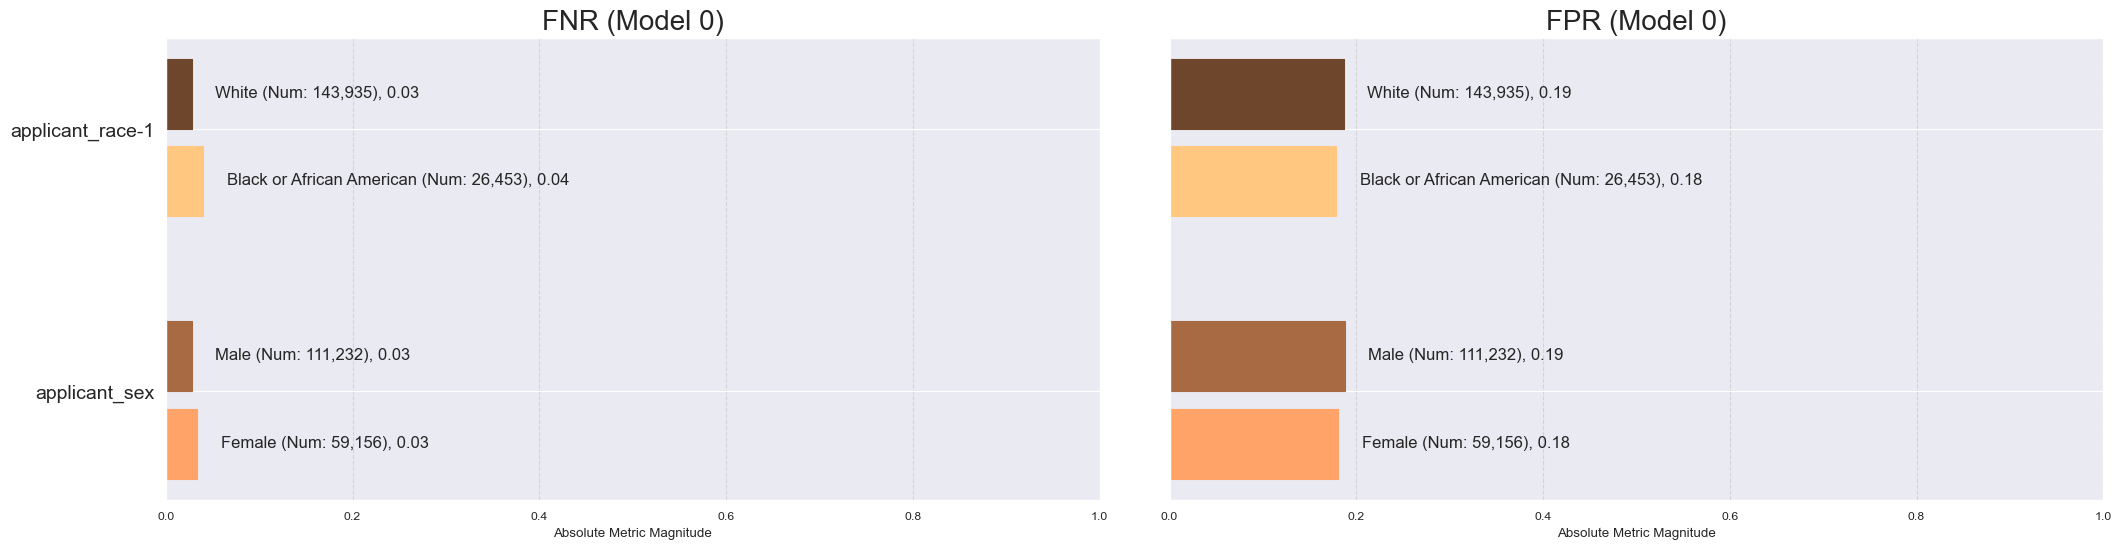

<Figure size 640x480 with 0 Axes>

In [30]:
group_metric_all = aqp.plot_group_metric_all(xtab, metrics=['fnr','fpr'], ncols=2)

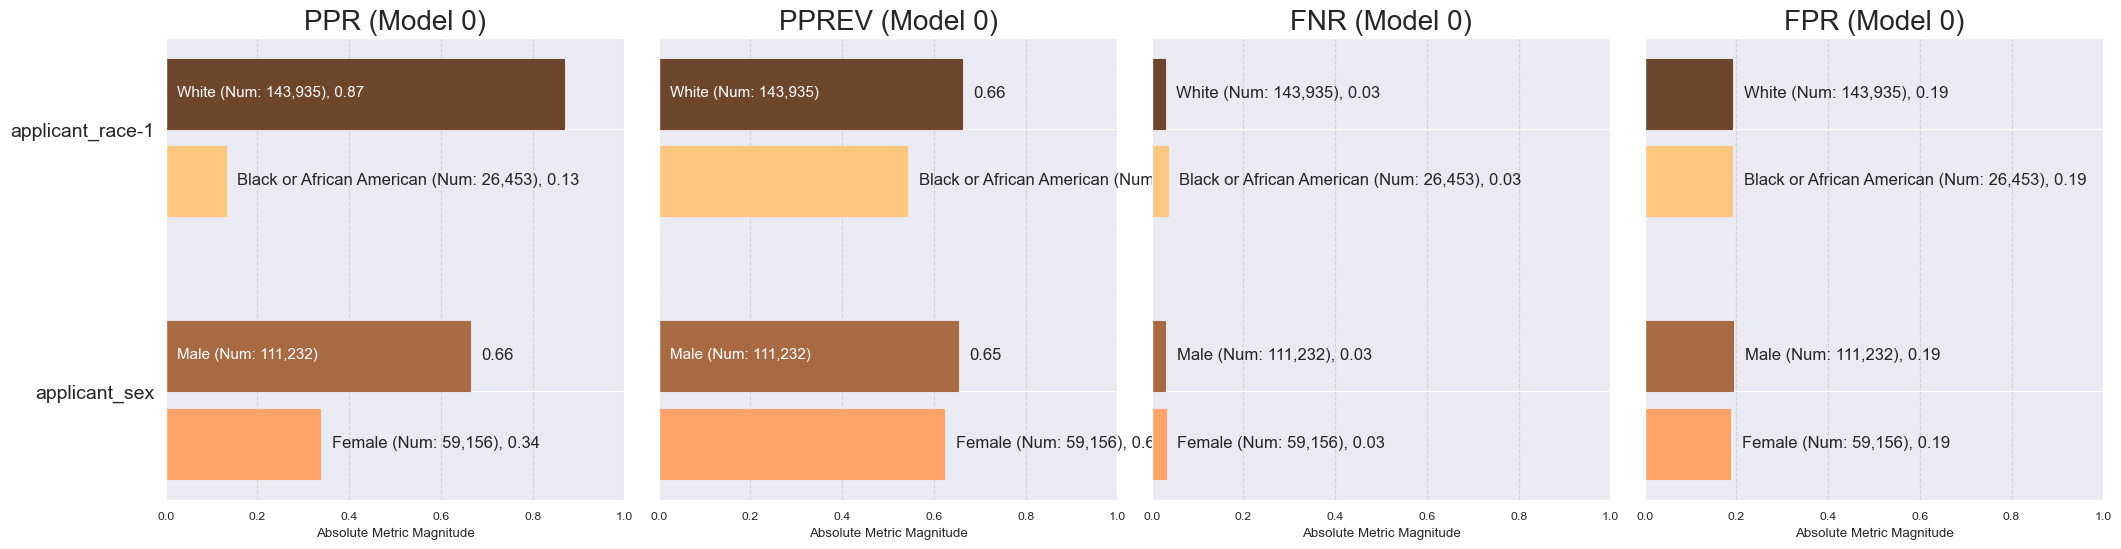

<Figure size 640x480 with 0 Axes>

In [31]:
group_metric_all_rew = aqp.plot_group_metric_all(xtab_rew, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

In [32]:
b = aequitas.bias.Bias()

In [33]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=results_ren, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex':'Male'}, alpha=0.05, mask_significance=True)
bdf.style

In [34]:
bdf_rew = b.get_disparity_predefined_groups(xtab_rew, original_df=results_ren_rew, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex': 'Male'}, alpha=0.05, mask_significance=True)
bdf_rew.style

In [35]:
original_model_results_total = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1': [f1_score(y_test, y_pred)],
    'roc_auc': [roc_auc_score(y_test, y_pred_proba)],
    'tpr_disparity': [bdf['tpr_disparity'][2]],
    'fpr_disparity': [bdf['fpr_disparity'][2]],
    'tnr_disparity': [bdf['tnr_disparity'][2]],
    'fnr_disparity': [bdf['fnr_disparity'][2]]
})

In [36]:
original_model_results_total

accuracy  precision    recall        f1   roc_auc  tpr_disparity  \
0  0.904894   0.878313  0.970316  0.922025  0.943971       0.987803   

   fpr_disparity  tnr_disparity  fnr_disparity  
0       0.955315       1.010275       1.419652

In [37]:
original_model_results_total_rew = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred_rew)],
    'precision': [precision_score(y_test, y_pred_rew)],
    'recall': [recall_score(y_test, y_pred_rew)],
    'f1': [f1_score(y_test, y_pred_rew)],
    'roc_auc': [roc_auc_score(y_test, y_pred_proba_rew)],
    'tpr_disparity': [bdf_rew['tpr_disparity'][2]],
    'fpr_disparity': [bdf_rew['fpr_disparity'][2]],
    'tnr_disparity': [bdf_rew['tnr_disparity'][2]],
    'fnr_disparity': [bdf_rew['fnr_disparity'][2]]
})

In [38]:
results_df = pd.concat([original_model_results_total, original_model_results_total_rew], axis=0)
results_df.index = ['Initial_Model', 'Iteration I']
results_df = results_df.T
results_df

Initial_Model  Iteration I
accuracy            0.904894     0.902493
precision           0.878313     0.875046
recall              0.970316     0.970296
f1                  0.922025     0.920212
roc_auc             0.943971     0.941941
tpr_disparity       0.987803     0.994071
fpr_disparity       0.955315     0.998854
tnr_disparity       1.010275     1.000271
fnr_disparity       1.419652     1.198473

In [39]:
import shap

def f(X):
    return model.predict([X[:, i] for i in range(X.shape[1])]).flatten()

In [40]:
shap.initjs()
explainer = shap.KernelExplainer(model.predict ,shap.sample(X_train_scaled, 100))

4/4 [==============================] - 0s 2ms/step


In [41]:
shap.initjs()
tf.autograph.set_verbosity(0)
shap_values = explainer.shap_values(X_test_scaled[:150], nsamples=150)

  0%|          | 0/150 [00:00<?, ?it/s]

469/469 [==============================] - 0s 977us/step


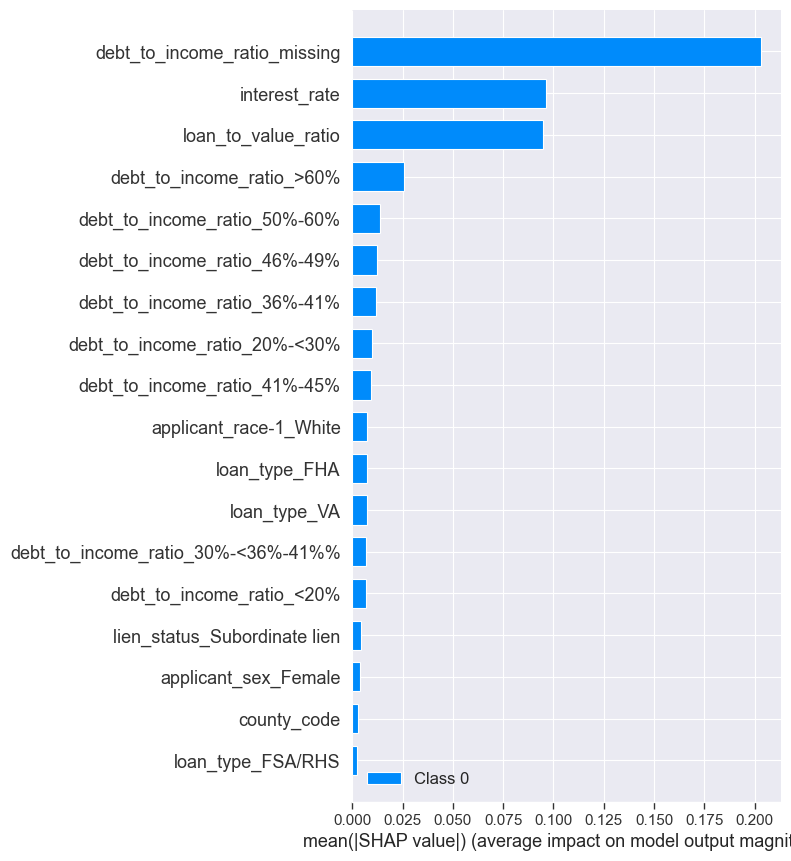

In [42]:
shap.summary_plot(shap_values, X_test_scaled[:150], feature_names=X.columns)

In [43]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test_scaled[:150], feature_names=X.columns)

In [44]:
explainer.expected_value

array([0.56890215])

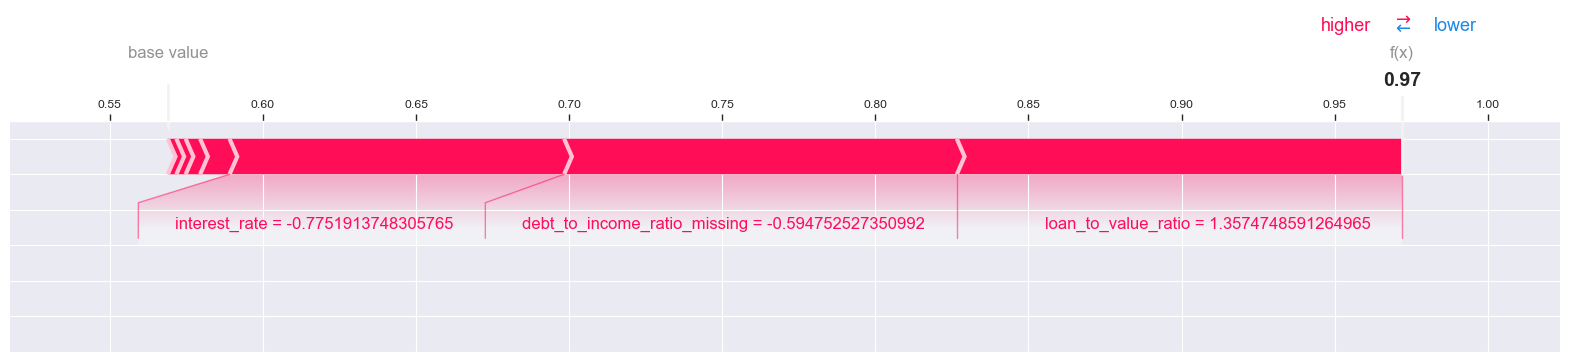

In [45]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][0], X_test_scaled[0], feature_names=X.columns, matplotlib=True)

In [46]:
for value in range(10):
    print(str(value) + ": Base value", explainer.expected_value, "Shapley value", shap_values[0][value].sum(), "Sum", shap_values[0][value].sum() + explainer.expected_value)

0: Base value [0.56890215] Shapley value 0.40315436088712897 Sum [0.97205651]
1: Base value [0.56890215] Shapley value -0.567157442739699 Sum [0.0017447]
2: Base value [0.56890215] Shapley value 0.38816552126081666 Sum [0.95706767]
3: Base value [0.56890215] Shapley value 0.2166162606445141 Sum [0.78551841]
4: Base value [0.56890215] Shapley value -0.4452240813407117 Sum [0.12367807]
5: Base value [0.56890215] Shapley value -0.5671393680968322 Sum [0.00176278]
6: Base value [0.56890215] Shapley value 0.3811581011977978 Sum [0.95006025]
7: Base value [0.56890215] Shapley value 0.3741783376899547 Sum [0.94308048]
8: Base value [0.56890215] Shapley value 0.3794875618186779 Sum [0.94838971]
9: Base value [0.56890215] Shapley value 0.023741888639051467 Sum [0.59264404]


In [47]:
y_pred_proba[:10]

array([0.9720565 , 0.00174471, 0.95706767, 0.78551847, 0.12367814,
       0.00176278, 0.9500603 , 0.9430805 , 0.9483897 , 0.59264404],
      dtype=float32)

In [48]:
pd.DataFrame(sorted(dict(zip(X.columns, shap_values[0][0])).items(), key=lambda x: x[1], reverse=True))

0         1
0                  loan_to_value_ratio  0.145456
1         debt_to_income_ratio_missing  0.128256
2                        interest_rate  0.109283
3            debt_to_income_ratio_>60%  0.009597
4               applicant_race-1_White  0.004734
5         debt_to_income_ratio_41%-45%  0.003025
6         debt_to_income_ratio_46%-49%  0.002804
7                          county_code  0.000000
8                 applicant_sex_Female  0.000000
9                        loan_type_FHA  0.000000
10                        loan_type_VA  0.000000
11                   loan_type_FSA/RHS  0.000000
12       debt_to_income_ratio_20%-<30%  0.000000
13  debt_to_income_ratio_30%-<36%-41%%  0.000000
14        debt_to_income_ratio_36%-41%  0.000000
15        debt_to_income_ratio_50%-60%  0.000000
16           debt_to_income_ratio_<20%  0.000000
17        lien_status_Subordinate lien  0.000000

In [49]:
explainer_rew = shap.KernelExplainer(model_rew.predict ,shap.sample(X_train_scaled, 100))
shap_values_rew = explainer_rew.shap_values(X_test_scaled[:150], nsamples=150)

4/4 [==============================] - 0s 2ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

469/469 [==============================] - 0s 921us/step


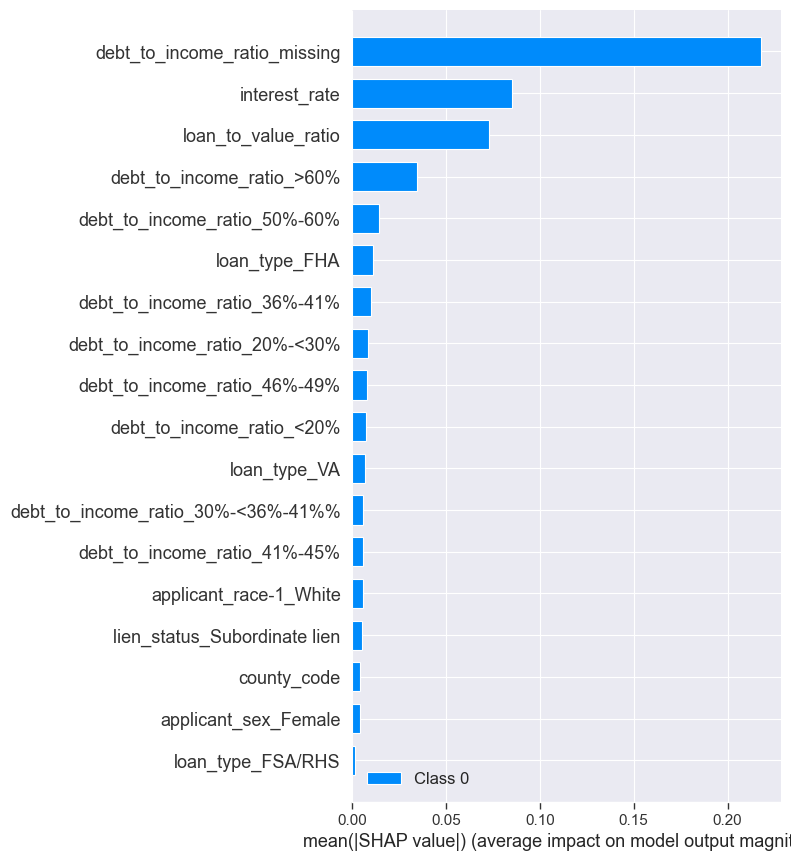

In [50]:
shap.summary_plot(shap_values_rew, X_test_scaled[:150], feature_names=X.columns)

In [51]:
shap.force_plot(explainer_rew.expected_value, shap_values_rew[0], X_test_scaled[:150], feature_names=X.columns)

In [52]:
explainer_rew.expected_value

array([0.57328115])

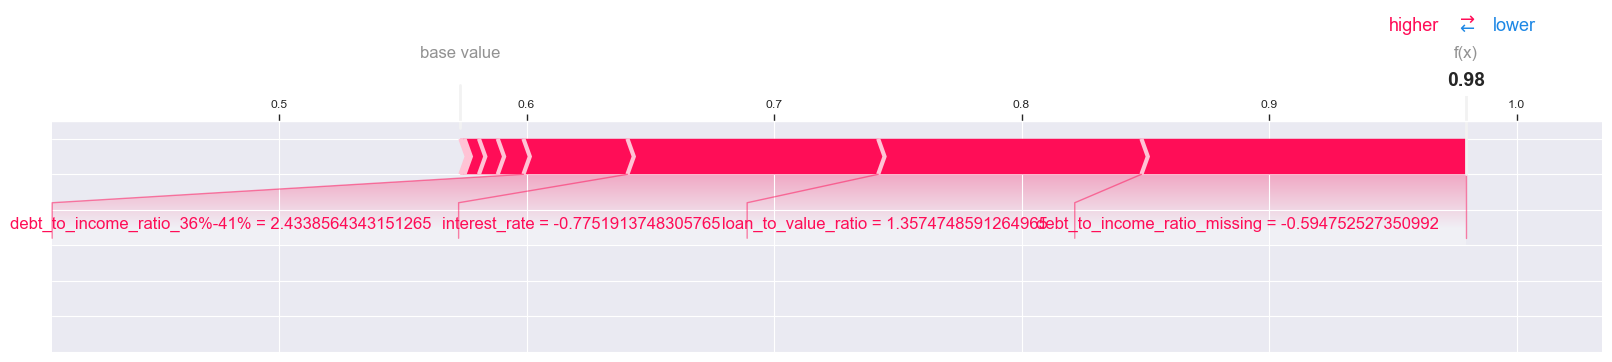

In [53]:
shap.initjs()
shap.force_plot(explainer_rew.expected_value, shap_values_rew[0][0], X_test_scaled[0], feature_names=X.columns, matplotlib=True)

In [54]:
print("Reweighed")
for value in range(10):
    print(str(value) + ": Base value", explainer_rew.expected_value, "Shapley value", shap_values_rew[0][value].sum(), "Sum", shap_values_rew[0][value].sum() + explainer_rew.expected_value)
print("Original")
for value in range(10):
    print(str(value) + ": Base value", explainer.expected_value, "Shapley value", shap_values[0][value].sum(), "Sum", shap_values[0][value].sum() + explainer.expected_value)

Reweighed
0: Base value [0.57328115] Shapley value 0.40629519947455256 Sum [0.97957635]
1: Base value [0.57328115] Shapley value -0.5697244202566799 Sum [0.00355673]
2: Base value [0.57328115] Shapley value 0.3721053195802961 Sum [0.94538647]
3: Base value [0.57328115] Shapley value 0.09970988758490418 Sum [0.67299104]
4: Base value [0.57328115] Shapley value -0.10993630758835937 Sum [0.46334484]
5: Base value [0.57328115] Shapley value -0.5697131065500435 Sum [0.00356804]
6: Base value [0.57328115] Shapley value 0.38131614454672674 Sum [0.95459729]
7: Base value [0.57328115] Shapley value 0.3677002383081708 Sum [0.94098139]
8: Base value [0.57328115] Shapley value 0.3762632799951825 Sum [0.94954443]
9: Base value [0.57328115] Shapley value 0.19519164093420838 Sum [0.76847279]
Original
0: Base value [0.56890215] Shapley value 0.40315436088712897 Sum [0.97205651]
1: Base value [0.56890215] Shapley value -0.567157442739699 Sum [0.0017447]
2: Base value [0.56890215] Shapley value 0.388165

In [55]:
pd.DataFrame(sorted(dict(zip(X.columns, shap_values_rew[0][0])).items(), key=lambda x: x[1], reverse=True))

0         1
0         debt_to_income_ratio_missing  0.131126
1                  loan_to_value_ratio  0.106364
2                        interest_rate  0.101312
3         debt_to_income_ratio_36%-41%  0.042019
4   debt_to_income_ratio_30%-<36%-41%%  0.010385
5         debt_to_income_ratio_50%-60%  0.007586
6            debt_to_income_ratio_>60%  0.005842
7         debt_to_income_ratio_46%-49%  0.001420
8            debt_to_income_ratio_<20%  0.000242
9                          county_code  0.000000
10                applicant_sex_Female  0.000000
11              applicant_race-1_White  0.000000
12                       loan_type_FHA  0.000000
13                        loan_type_VA  0.000000
14                   loan_type_FSA/RHS  0.000000
15       debt_to_income_ratio_20%-<30%  0.000000
16        debt_to_income_ratio_41%-45%  0.000000
17        lien_status_Subordinate lien  0.000000

In [56]:
shap_diff_race_orig = []
for i in range(15):
    shap_diff_race_orig.append(shap_values[0][i][4])

shap_diff_race_rew = []
for i in range(15):
    shap_diff_race_rew.append(shap_values_rew[0][i][4])

pd.DataFrame({'Original': shap_diff_race_orig, 'Reweighed': shap_diff_race_rew})

Original  Reweighed
0   0.004734   0.000000
1   0.000000   0.000000
2   0.000000   0.000000
3   0.025521   0.007608
4  -0.040969   0.000000
5   0.000000   0.000000
6   0.000000   0.000000
7   0.000000   0.000000
8   0.000000   0.000000
9   0.000000   0.000000
10 -0.032074  -0.023840
11  0.000000   0.000000
12 -0.076654  -0.039208
13  0.000000   0.001899
14 -0.020231  -0.020780

In [57]:
import lime.lime_tabular

In [58]:
lime_exp = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, mode="classification", feature_names=X.columns)

In [59]:
explained_lime = lime_exp.explain_instance(X_test_scaled[0], model.predict, num_features=15, top_labels=1)

157/157 [==============================] - 0s 826us/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


In [60]:
explained_lime.show_in_notebook(show_table=True, show_all=False)

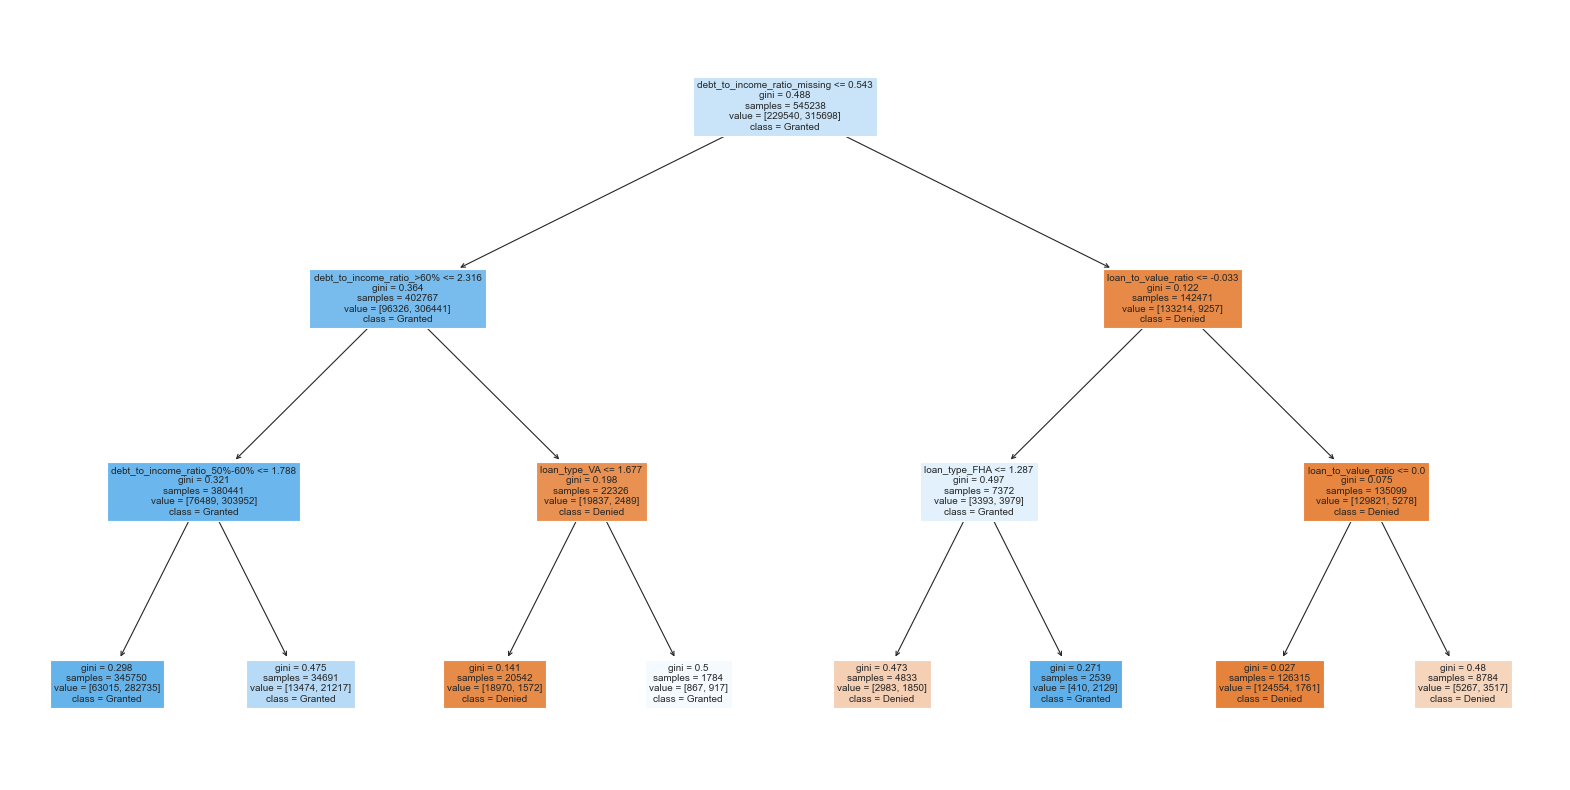

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train_scaled, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, filled=True, class_names=['Denied', 'Granted'])
plt.show()

In [62]:
X_train_original = X_train_scaled
X_val_original = X_val_scaled
X_test_original = X_test_scaled
y_train_original = y_train
y_val_original = y_val

from sklearn.tree import DecisionTreeClassifier
surrogate_model = DecisionTreeClassifier()

surrogate_model.fit(X_train_original, y_train_original)

surrogate_accuracy = surrogate_model.score(X_test_original, y_test)
feature_importance = surrogate_model.feature_importances_

In [63]:
surrogate_accuracy

0.8927037115289809

In [64]:
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df

feature  importance
16        debt_to_income_ratio_missing    0.464715
1                        interest_rate    0.154656
2                  loan_to_value_ratio    0.143724
15           debt_to_income_ratio_>60%    0.090883
0                          county_code    0.063538
6                         loan_type_VA    0.016067
5                        loan_type_FHA    0.014178
13        debt_to_income_ratio_50%-60%    0.012217
3                 applicant_sex_Female    0.007984
4               applicant_race-1_White    0.006590
17        lien_status_Subordinate lien    0.006448
14           debt_to_income_ratio_<20%    0.003715
10        debt_to_income_ratio_36%-41%    0.003201
9   debt_to_income_ratio_30%-<36%-41%%    0.002910
8        debt_to_income_ratio_20%-<30%    0.002811
11        debt_to_income_ratio_41%-45%    0.002725
12        debt_to_income_ratio_46%-49%    0.002718
7                    loan_type_FSA/RHS    0.000920

In [65]:
global_surrogate_model = DecisionTreeClassifier()
global_surrogate_model.fit(X_train_original, y_train_original)

global_surrogate_accuracy = global_surrogate_model.score(X_test_original, y_pred)
global_feature_importance = global_surrogate_model.feature_importances_

In [66]:
global_surrogate_accuracy

0.9406824424255229

In [67]:
global_feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': global_feature_importance})
global_feature_importance_df = global_feature_importance_df.sort_values('importance', ascending=False)
global_feature_importance_df

feature  importance
16        debt_to_income_ratio_missing    0.464715
1                        interest_rate    0.154746
2                  loan_to_value_ratio    0.143354
15           debt_to_income_ratio_>60%    0.090883
0                          county_code    0.063721
6                         loan_type_VA    0.016093
5                        loan_type_FHA    0.014220
13        debt_to_income_ratio_50%-60%    0.012217
3                 applicant_sex_Female    0.008106
4               applicant_race-1_White    0.006578
17        lien_status_Subordinate lien    0.006502
14           debt_to_income_ratio_<20%    0.003732
10        debt_to_income_ratio_36%-41%    0.003131
8        debt_to_income_ratio_20%-<30%    0.002882
9   debt_to_income_ratio_30%-<36%-41%%    0.002878
11        debt_to_income_ratio_41%-45%    0.002780
12        debt_to_income_ratio_46%-49%    0.002572
7                    loan_type_FSA/RHS    0.000890

In [72]:
X_train_scaled

array([[-1.44813610e+00,  3.55598300e-01,  1.55154613e+00, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.43057973e-01, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.39506631e-01, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01,  1.68137159e+00,  2.46483423e+00],
       ...,
       [ 5.41033231e-01, -1.39650438e+00, -1.05098414e+00, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.66037244e-01, -8.78743543e-01, -4.76921098e-01, ...,
        -2.06628944e-01,  1.68137159e+00, -4.05706796e-01],
       [-2.28186586e+00, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01,  1.68137159e+00, -4.05706796e-01]])

In [80]:
import lightgbm as lgb

In [90]:
import numpy as np
import pandas as pd
import lightgbm as lgb

# Assuming you already have X_train_scaled, y_train, X_test_scaled, and S defined

# If X_train_scaled is a NumPy array, you can't directly access its dtypes attribute
# Instead, if you want to check the data types, you can convert it to a DataFrame first
X_train_scaled_df = pd.DataFrame(X_train_scaled)

# Check data types
print(X_train_scaled_df.dtypes)

# Check for missing values
print(np.isnan(X_train_scaled).sum())

# Check if sensitive attribute S is aligned with training data
print(len(S), len(X_train_scaled))

# Assuming you've checked and resolved any issues with data types, missing values, and alignment
# Continue with model training

train_data = lgb.Dataset(X_train_scaled, label=y_train)

constraint = lgb.Dataset(X_train_scaled, label=y_train, group=S)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 3,
    "min_data_in_leaf": 2,
    "feature_fraction": 1.0,
    "random_state": 42,
    "verbose": -1  # Set verbosity level
}

try:
    fairgbm_mod = lgb.train(params, train_data, valid_sets=[constraint])
    y_pred_fairgbm = fairgbm_mod.predict(X_test_scaled)
except Exception as e:  # Catch all exceptions
    print("Error:", e)


0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
dtype: object
0
545238 545238


Found `n_estimators` in params. Will use it instead of argument


Error: Sum of query counts (545238) differs from the length of #data (84175)


In [91]:
print("Length of X_train_scaled:", len(X_train_scaled))
print("Length of S:", len(S))


Length of X_train_scaled: 545238
Length of S: 545238
